In [9]:
import skimage.io as io
import matplotlib.pyplot as plt
import numpy as np
from skimage.exposure import histogram
from matplotlib.pyplot import bar
from skimage.color import rgb2gray,rgb2hsv
from pathlib import Path
# Convolution:
from scipy.signal import convolve2d
from scipy import fftpack
import math
from functools import cmp_to_key
from skimage.util import random_noise
from skimage.filters import median
from skimage.feature import canny
import commonfunctions as cf # this a custom module found the commonfunctions.py
import cv2
import numpy as np
import os


# Edges
from skimage.filters import sobel_h, sobel, sobel_v,roberts, prewitt

# Show the figures / plots inside the notebook
def show_images(images,titles=None):
    #This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    # You aren't required to understand this function, use it as-is.
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show() 


def showHist(img):
    # An "interface" to matplotlib.axes.Axes.hist() method
    plt.figure()
    imgHist = histogram(img, nbins=256)
    
    bar(imgHist[1].astype(np.uint8), imgHist[0], width=0.8, align='center')


alpha = 1.0
beta = 0.0
# Function to perform the perspective transformation
def perspective_transform(img,binary):

    if img is None:
        print(f"Error: Unable to load the image.")
    else:
        # Convert the image to grayscale
        binary_image=0
        if binary==0:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Apply thresholding to create a binary image
            _, binary_image = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY)
        else :
            binary_image=img
        # cf.show_images([binary_image])
        # Find contours in the binary image
        contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Find the largest contour based on area
        print(len(contours))
        largest_contour = max(contours, key=cv2.contourArea)
        # Approximate the contour to a polygon
        epsilon = 0.02 * cv2.arcLength(largest_contour, True)
        approx_polygon = cv2.approxPolyDP(largest_contour, epsilon, True)

        # Get the four corners of the polygon
        corners = approx_polygon.reshape(-1, 2)
        corners = sorted(corners, key=lambda x: x[1])
        # Separate the sorted corners into top and bottom
        top_corners = sorted(corners[:2], key=lambda x: x[0])
        bottom_corners = sorted(corners[2:], key=lambda x: x[0])

        # Concatenate the sorted corners
        sorted_corners = np.concatenate([bottom_corners, top_corners])

        # Define the destination points for the perspective transformation
        dst_points = np.float32([[0, img.shape[0]], [img.shape[1], img.shape[0]], [0, 0], [img.shape[1], 0]])

        # Calculate the perspective transformation matrix
        matrix = cv2.getPerspectiveTransform(sorted_corners.astype(np.float32), dst_points)

        # Apply the perspective transformation to the image
        warped_img = cv2.warpPerspective(img, matrix, (img.shape[1], img.shape[0]))
        return warped_img
def invert_image(img):
    clone =img
    adjusted_img = cv2.addWeighted(img, alpha, np.zeros(img.shape, img.dtype), 0, beta)
    # cf.show_images([adjusted_img])
    img=perspective_transform(adjusted_img,0)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh_image = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,91, 5)
    thresh_image=255-thresh_image
    trial = perspective_transform(thresh_image,1)
    # cf.show_images([thresh_image])
    transform=perspective_transform(thresh_image,1)
    return transform


8
3244
1890
11222
11222


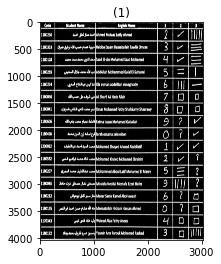

from vertical lines [array([[   0, 1284,    0, 1104]], dtype=int32), array([[  1, 231,   1,  21]], dtype=int32), array([[  2, 652,   2, 302]], dtype=int32), array([[   9, 3532,    9, 3341]], dtype=int32), array([[   9, 2632,    9, 2113]], dtype=int32), array([[  10, 4030,   10, 3465]], dtype=int32), array([[  10, 2112,   10, 1735]], dtype=int32), array([[  11, 1734,   11, 1510]], dtype=int32), array([[  12, 1548,   12, 1285]], dtype=int32), array([[  13, 1168,   13,  865]], dtype=int32), array([[ 13, 567,  13, 365]], dtype=int32), array([[ 14, 864,  14, 694]], dtype=int32), array([[ 264, 2267,  264, 2084]], dtype=int32), array([[ 264, 1942,  264, 1779]], dtype=int32), array([[ 265, 2860,  265, 2654]], dtype=int32), array([[ 265, 2034,  265, 1838]], dtype=int32), array([[ 265, 1736,  265, 1433]], dtype=int32), array([[ 266, 1506,  266, 1076]], dtype=int32), array([[ 266, 3637,  266, 3415]], dtype=int32), array([[ 266, 3392,  266, 3109]], dtype=int32), array([[267, 984, 267, 777]], dtype

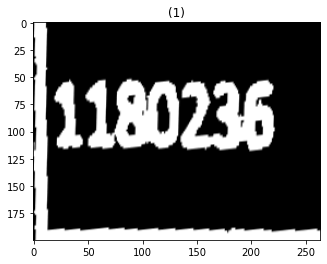

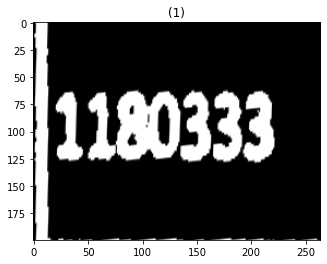

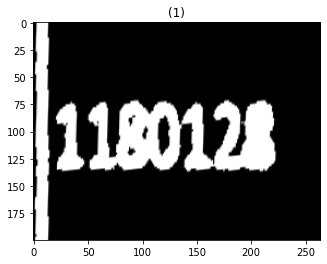

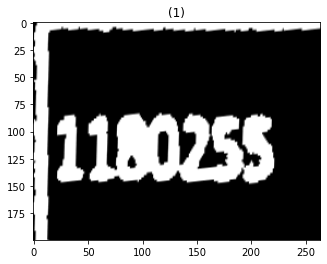

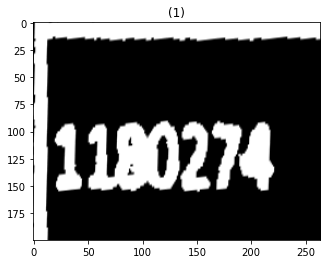

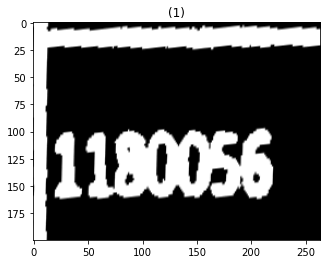

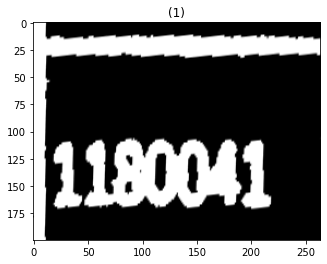

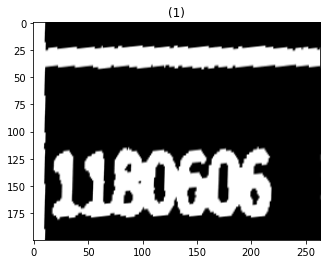

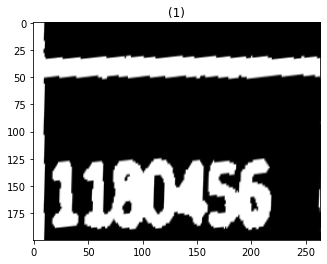

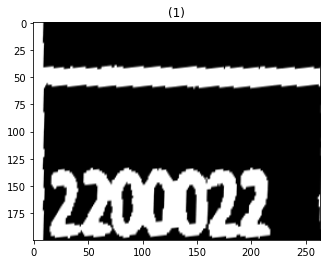

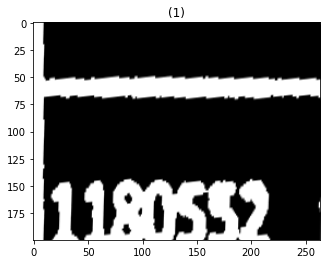

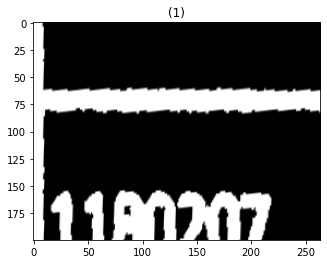

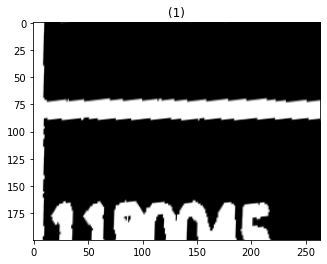

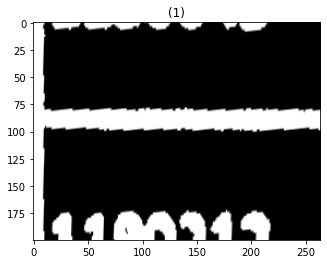

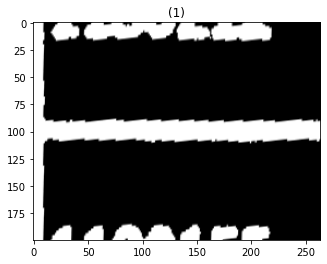

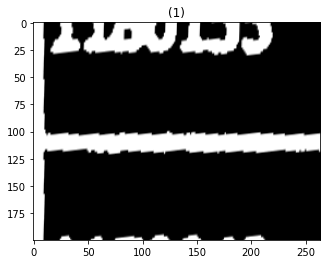

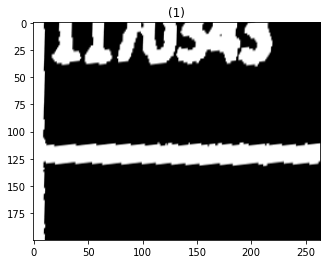

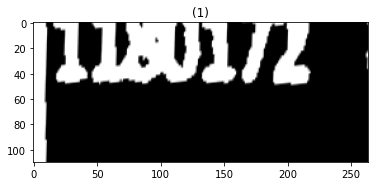

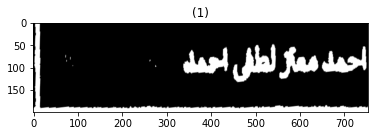

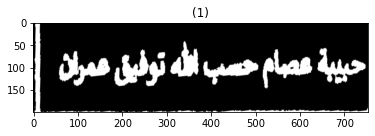

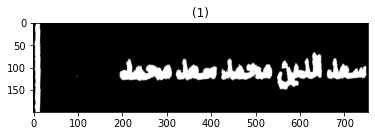

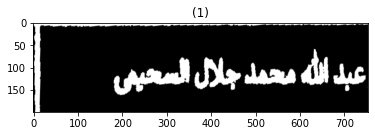

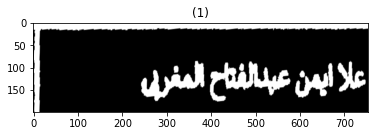

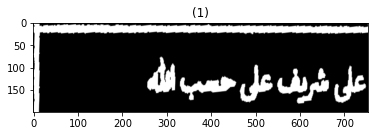

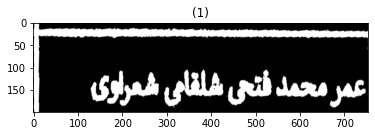

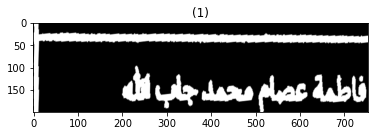

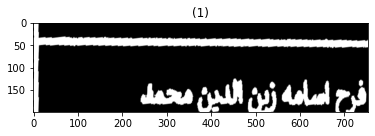

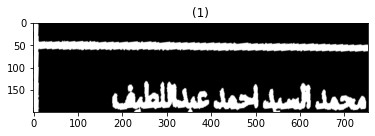

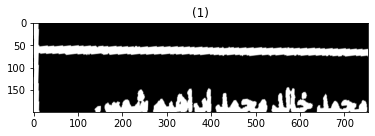

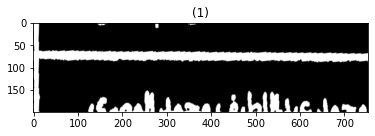

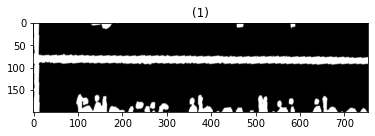

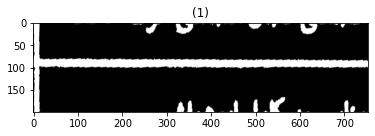

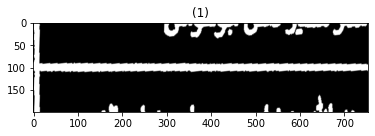

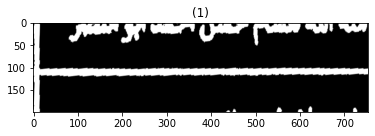

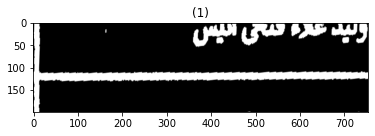

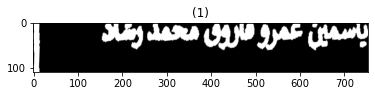

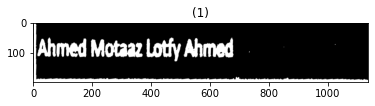

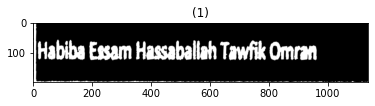

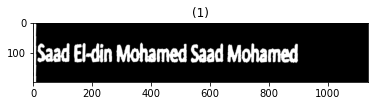

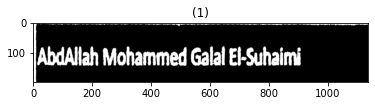

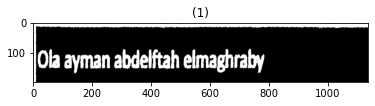

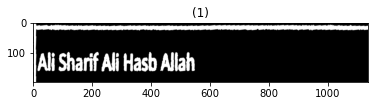

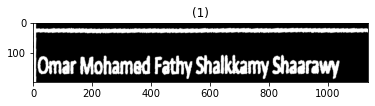

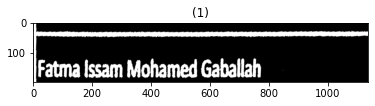

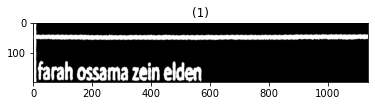

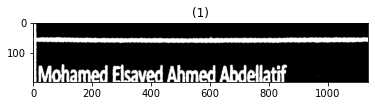

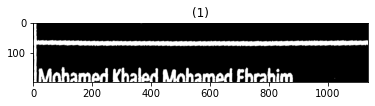

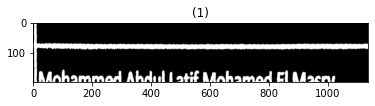

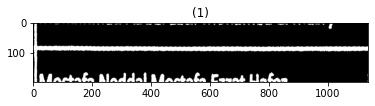

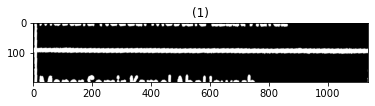

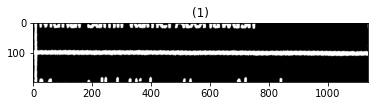

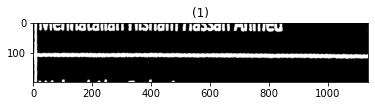

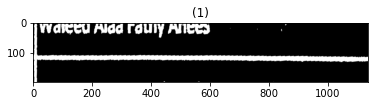

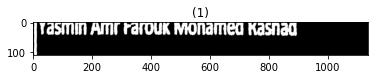

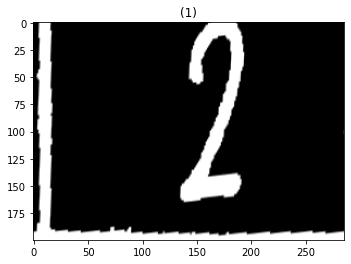

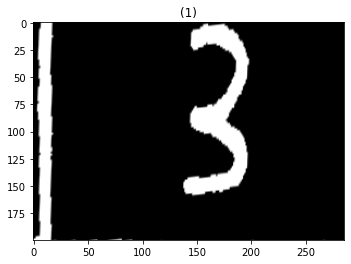

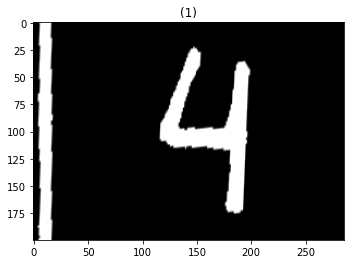

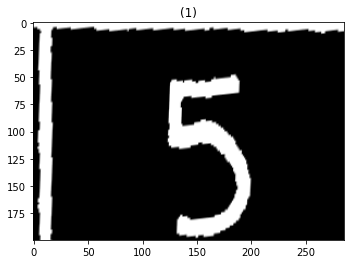

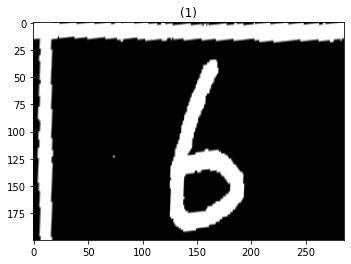

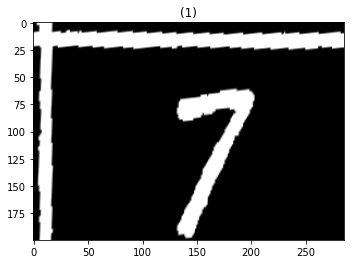

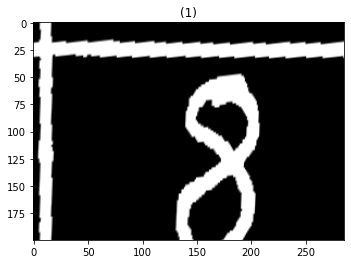

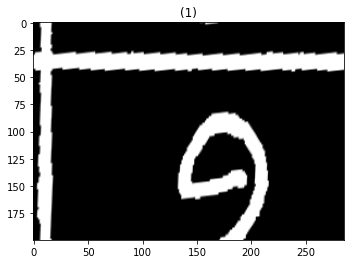

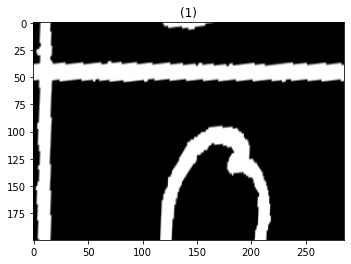

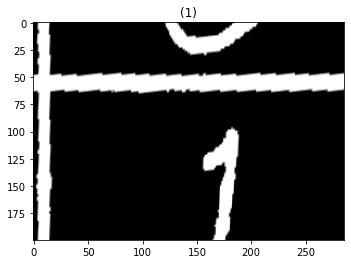

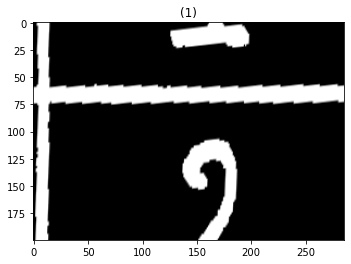

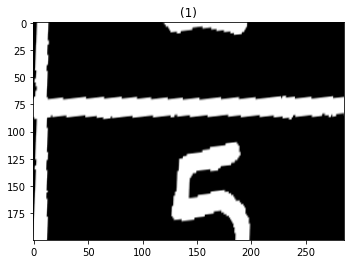

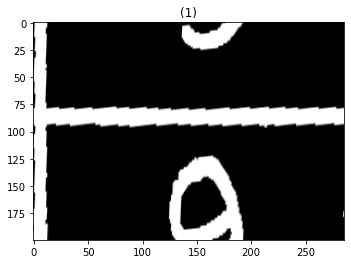

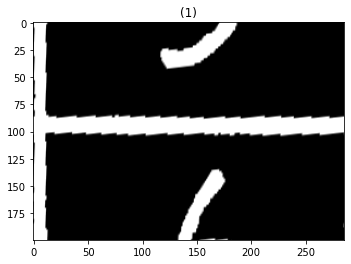

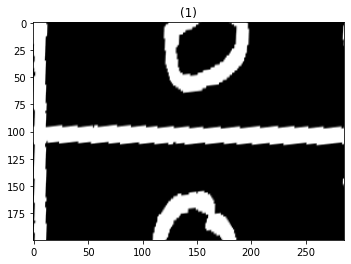

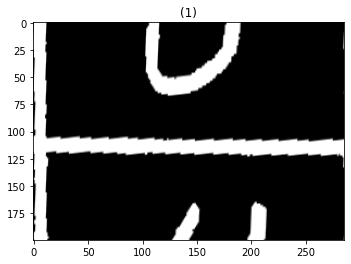

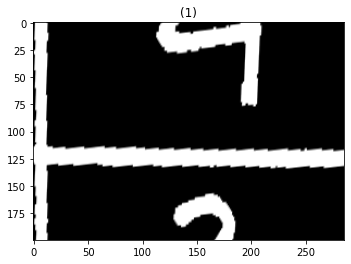

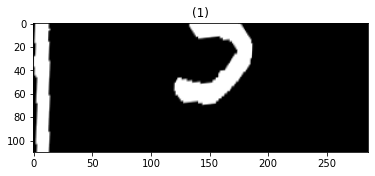

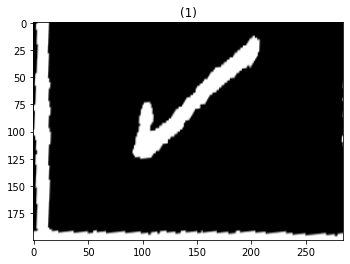

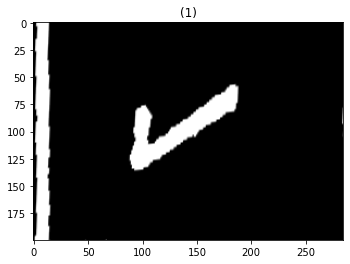

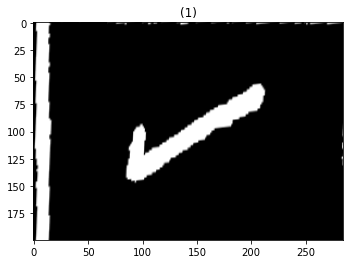

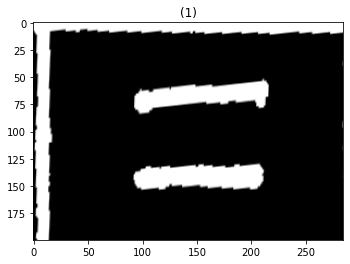

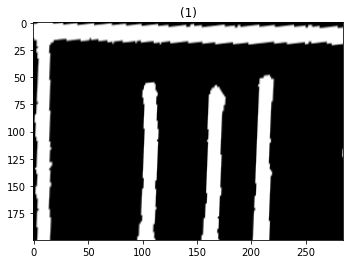

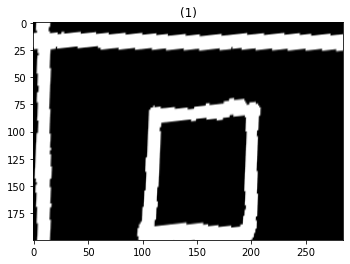

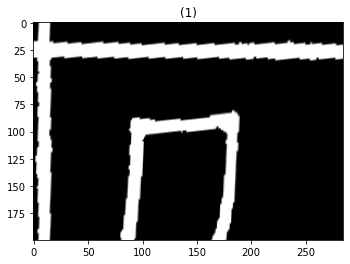

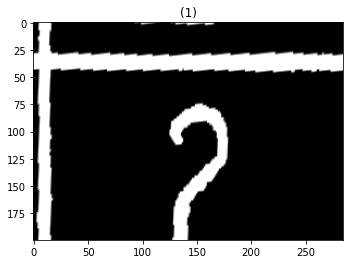

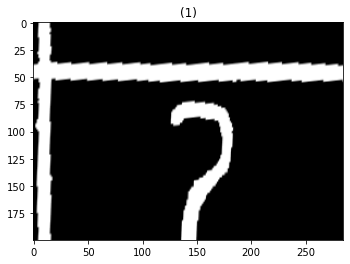

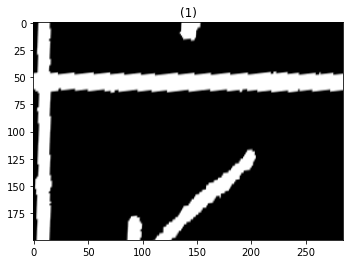

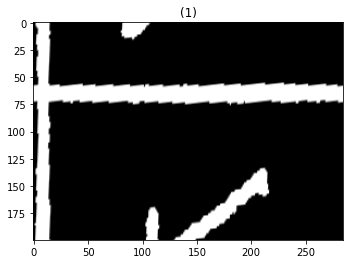

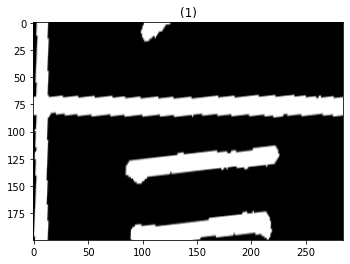

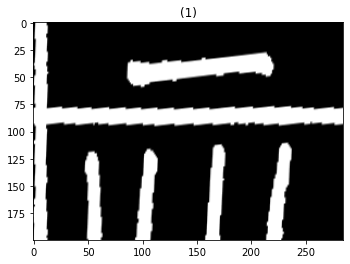

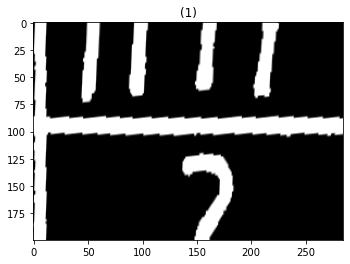

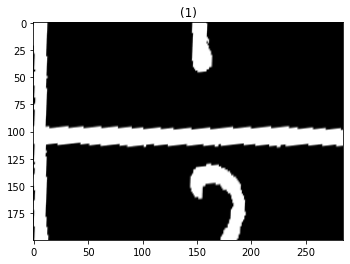

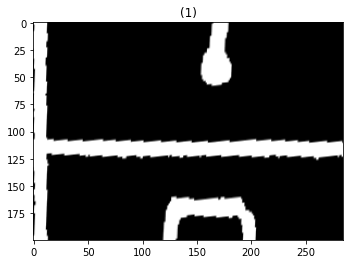

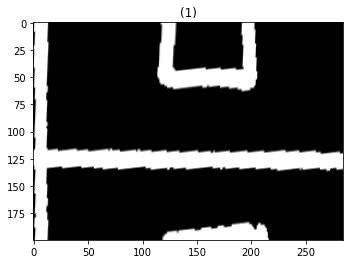

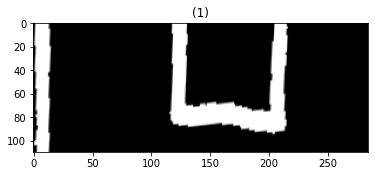

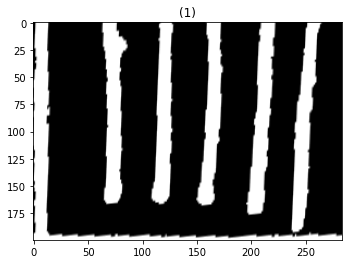

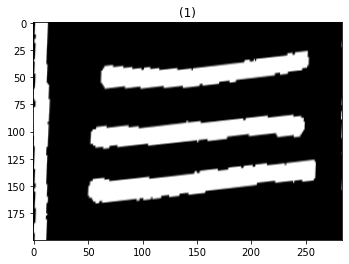

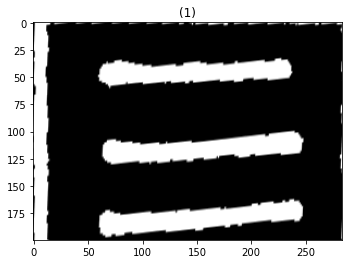

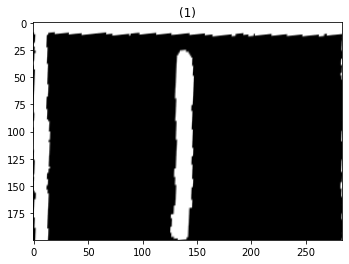

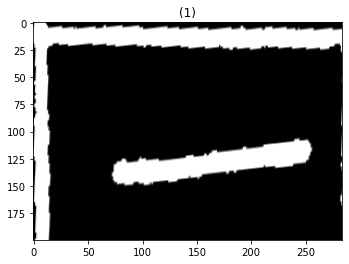

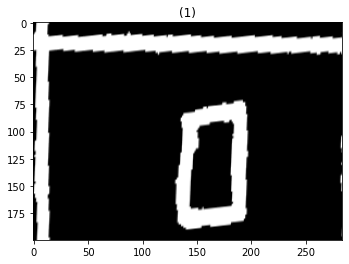

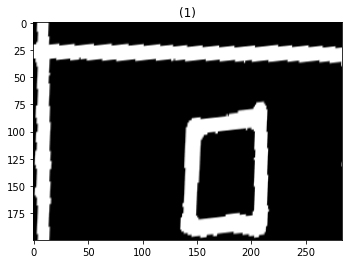

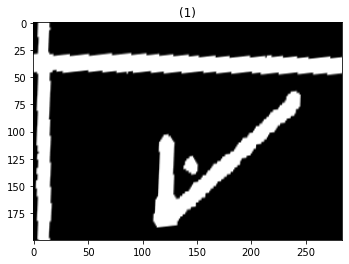

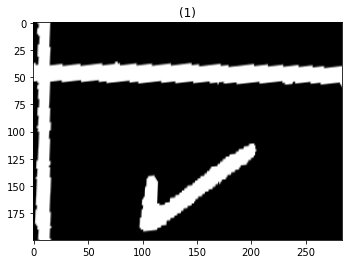

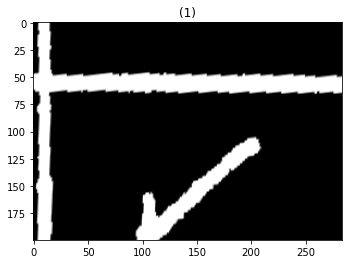

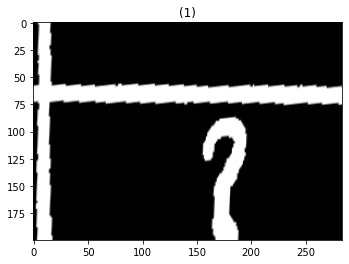

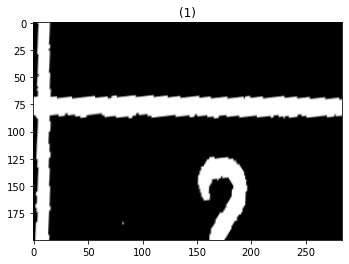

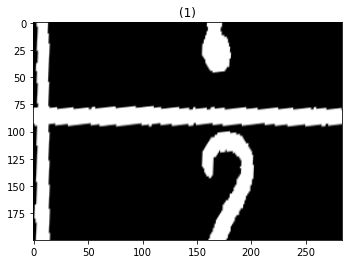

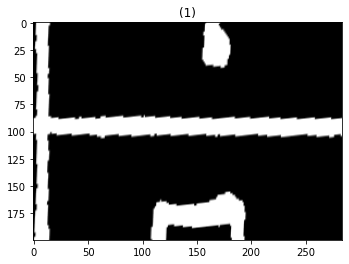

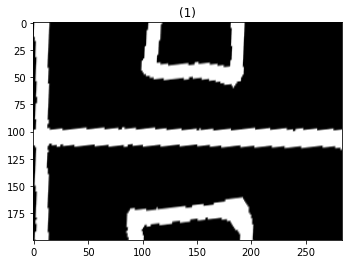

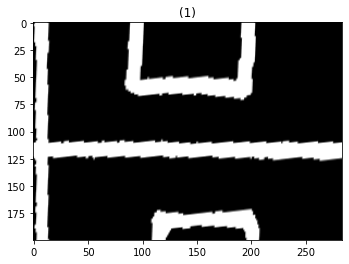

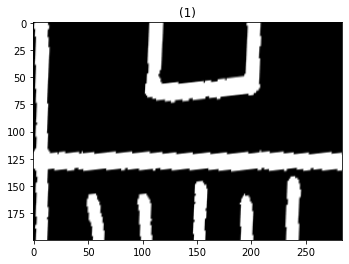

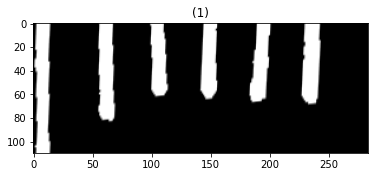

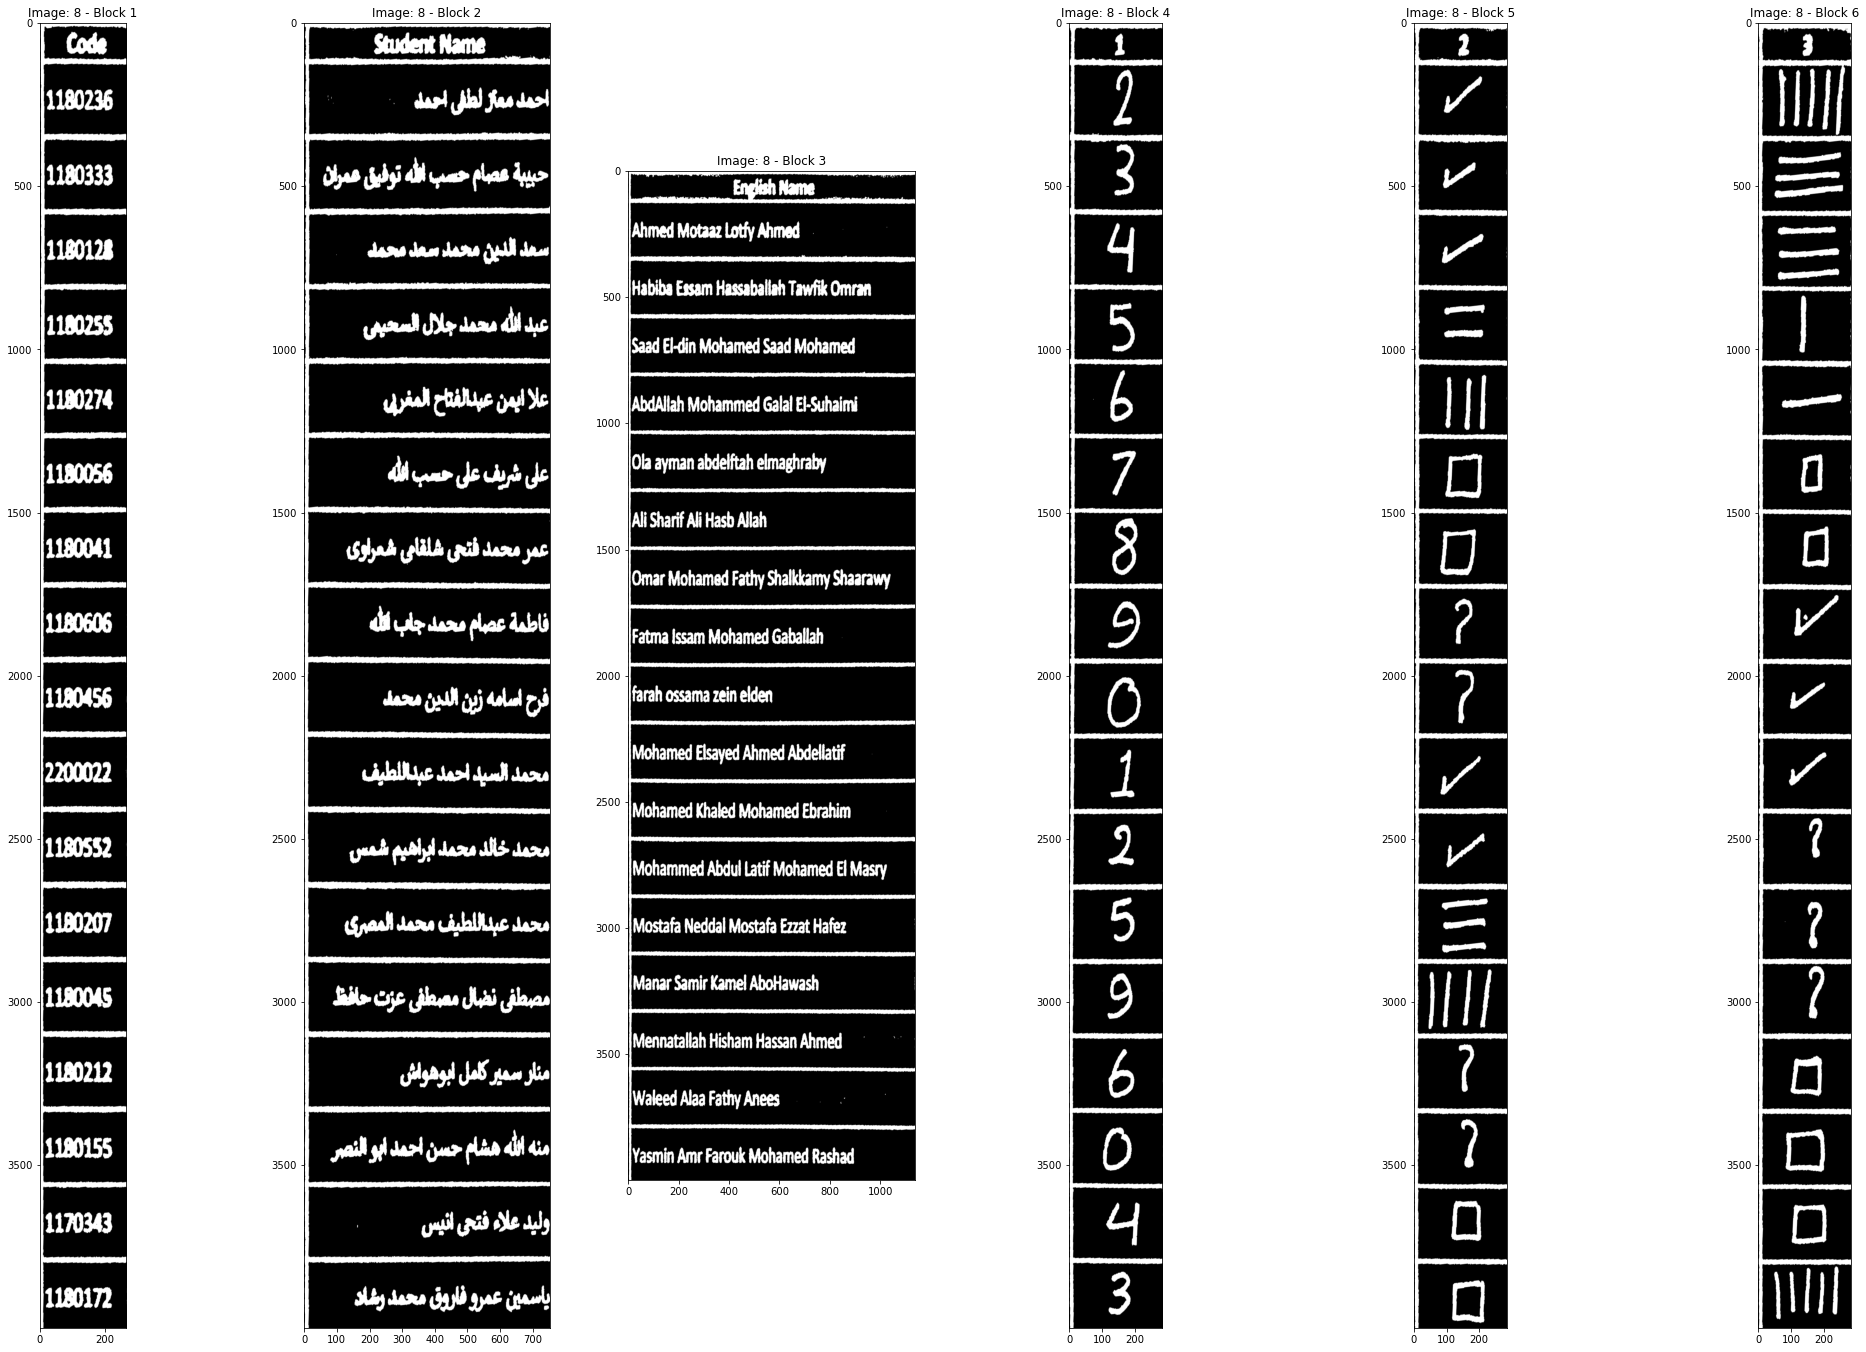

In [10]:

arr=[[] for _ in range (6)]
def readImage(imgpath):
    img=cv2.imread(imgpath)
    transformed_img = perspective_transform(img, 0)
    inverted_img=invert_image(transformed_img)
    show_images([inverted_img])
    return inverted_img
def getVerticalLines(inverted_img):
    # Apply edge detection using Canny edge detector
    edges = cv2.Canny(inverted_img, 50, 150, apertureSize=3)
    # Perform Hough Line Transform for vertical lines
    rho = 1  # 1 pixel
    theta = np.pi # Vertical lines (90 degrees)
    threshold = 260  # Adjust this value as needed
    min_line_length = 160  # Minimum line length
    max_line_gap = 20  # Maximum allowed gap between line segments

    lines = cv2.HoughLinesP(edges, rho=rho, theta=theta, threshold=threshold,
                            minLineLength=min_line_length, maxLineGap=max_line_gap)
    sorted_lines = sorted(lines, key=lambda line: line[0][0])
    print("from vertical lines",sorted_lines)
    filtered_lines = [sorted_lines[0]]
    for line in sorted_lines[1:]:
        prev_x = filtered_lines[-1][0][0] 
        cur_x = line[0][0]  

        if cur_x - prev_x >= 20:
            filtered_lines.append(line)  
    return filtered_lines
def getBlocks(lines,cur_Seg,inverted_img):
    x1=lines[0][0][0]
    idx=0
    for line in lines:
        x2=line[0][0]
        if(x2-x1>cur_Seg[0]):
            block = inverted_img[0:4000, x1:x2]
            break      
        idx=idx+1
    y1 = 150
    while y1 < block.shape[0]:
        cell = block[y1:y1 + 200, :]
        show_images([cell])
        arr[cur_Seg[1]].append(cell)
        y1 += 220
    return [block,idx]
segs=[[50,0],[100,1],[200,2],[50,3],[50,4],[50,5]]
def getImageBlocks(filtered_lines,inverted_img):
    idx = 0
    block_images = [] 
    for i in range(len(segs)):
        [block, nwidx] = getBlocks(filtered_lines[idx:], segs[i],inverted_img)
        idx = idx + nwidx
        block_images.append(block)  
    return block_images
    
    
samples_dir = './Samples/'
for i in range(8, 9):
    print(i)
    image_path = os.path.join(samples_dir, f"{i}.jpg")
    inverted_img = readImage(image_path)
    filtered_lines = getVerticalLines(inverted_img)
    blocks=getImageBlocks(filtered_lines, inverted_img)
    # for j in range (0,1):
    #     getcells(blocks[j])
    block_titles = [f"Image: {i} - Block {j+1}" for j in range(len(blocks))]
    show_images(blocks, block_titles)



In [11]:
def contour_sort(a, b):

    br_a = cv2.boundingRect(a)
    br_b = cv2.boundingRect(b)

    if abs(br_a[0] - br_b[0]) <= 5:
        return br_a[1] - br_b[1]

    return br_a[0] - br_b[0]


def sorted_counter (contours):

    return sorted(contours, key=cmp_to_key(contour_sort))

In [12]:

def largest_contour(contours):
    largest_contour = np.array([])
    max_area = 0
    for contour in contours:
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.1 * perimeter, True)
        if area > max_area and len(approx) == 4:
            largest_contour = approx
            max_area = area
    return largest_contour
def Prespective_Transform(img_original):
    img =img_original.copy()
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray_image = cv2.bilateralFilter(gray_image, 20, 30, 30)

    edges = cv2.Canny(gray_image, 20, 120)
    edges = cv2.dilate(edges.copy(), None, 2)

    contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    biggest = largest_contour(contours[2:10])
    if(biggest.size!=8):
        biggest = largest_contour(contours[0:1])
    
    pts = biggest.reshape(4, 2)

    pts_sum = pts.sum(axis=1)

    top_left = pts[np.argmin(pts_sum)]
    bottom_right = pts[np.argmax(pts_sum)]

    pts_diff = np.diff(pts, axis=1)
    top_right = pts[np.argmin(pts_diff)]
    bottom_left = pts[np.argmax(pts_diff)]


    #Image Dimensions
    bottom_width = np.sqrt(pow((bottom_right[0] - bottom_left[0]), 2) + (pow((bottom_right[1] - bottom_left[1]), 2)))
    top_width = np.sqrt(pow((top_right[0] - top_left[0]), 2) + (pow((top_right[1] - top_left[1]), 2)))
    right_height = np.sqrt(pow((top_right[0] - bottom_right[0]), 2) + (pow((top_right[1] - bottom_right[1]), 2)))
    left_height = np.sqrt(pow((top_left[0] - bottom_left[0]), 2) + (pow((top_left[1] - bottom_left[1]), 2)))


    # Output image size
    width = max(int(bottom_width), int(top_width))
    height = max(int(right_height), int(left_height))
    # Points with new Coordinates 
    converted_points = np.float32([[0, 0], [width, 0], [0, height], [width, height]])
    arr = np.float32([top_left, top_right, bottom_left, bottom_right])
    matrix = cv2.getPerspectiveTransform(arr, converted_points)
    img_output = cv2.warpPerspective(img_original, matrix, (width, height))
    return img_output

In [13]:

def saveImg(directory, suffix, id,img):
    Path(directory).mkdir(parents=True, exist_ok=True)
    cv2.imwrite(f"{directory}/{suffix}_{id}.jpg", img)
def getCells(img):
    img_bin = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    (thresh, img_bin) = cv2.threshold(img, 128, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    img_bin = 255 - img_bin

    filter_dim = np.array(img).shape[1] // 38
    
    v_filter = cv2.getStructuringElement(cv2.MORPH_RECT, (1, filter_dim))
    h_filter = cv2.getStructuringElement(cv2.MORPH_RECT, (filter_dim, 1))
    filter = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

    v_lines = cv2.erode(img_bin, v_filter, iterations=3)
    v_lines = cv2.dilate(v_lines, v_filter, iterations=3)
    lines_ver = cv2.HoughLinesP(v_lines, 1, np.pi / 180, 40, minLineLength=10, maxLineGap=20)

    for line in lines_ver:
        for x1, y1, x2, y2 in line:
            v_lines = cv2.line(v_lines, (x1, 0), (x2, v_lines.shape[0]), (255, 255, 255), 1)

    h_lines = cv2.erode(img_bin, h_filter, iterations=4)
    h_lines = cv2.dilate(h_lines, h_filter, iterations=3)
    lines_hor = cv2.HoughLinesP(h_lines, 2, np.pi / 180, 40, minLineLength=5, maxLineGap=10)

    for line in lines_hor:
        for x1, y1, x2, y2 in line:
            h_lines = cv2.line(h_lines, (0, y1), (h_lines.shape[1], y2), (255, 255, 255), 1)

    final_img = cv2.bitwise_and(v_lines, h_lines)
    final_img = cv2.erode(~final_img, filter, iterations=1)
    (thresh, img_output) = cv2.threshold(final_img, 128,255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU) 
    show_images([img_output])
    return img_output


def cutCells(img, orignal_img,output_dir):
    contours = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]
    contours = sorted_counter(contours)
    rows = []

    for c in range(len(contours)-1):
        x1, y1, w1, h1 = cv2.boundingRect(contours[c])
        x2, y2, w2, h2 = cv2.boundingRect(contours[c+1])
        
        if x1 == x2:
            rows.append(y1)
        else:
            rows.append(y1)
            break

    num_hor = len(rows)
    num_ver = len(contours) 
    arr=["Code","Student Name","English Name","1","2","3"]
    for col in range(0, 6):
        for row in range(1, num_hor-1):
            x1, y1, w1, h1 = cv2.boundingRect(contours[row+num_hor*col])
            x2, y2, w2, h2 = cv2.boundingRect(contours[row+1+num_hor*col])
            x3, y3, w3, h3 = cv2.boundingRect(contours[row+num_hor*col+num_hor+1])
            new_img = orignal_img[y1+h1:y3, x2+w2:x3]
            # show_images([new_img])
            saveImg(output_dir,arr[col],row,new_img)

1.jpg


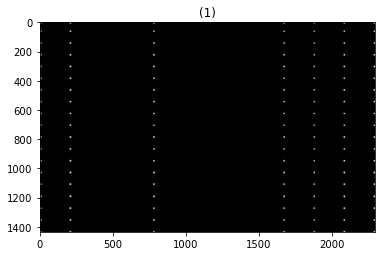

10.jpg


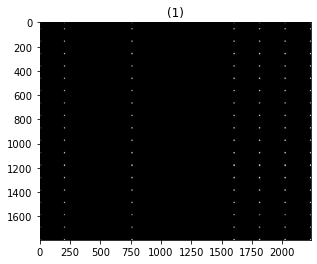

11.jpg


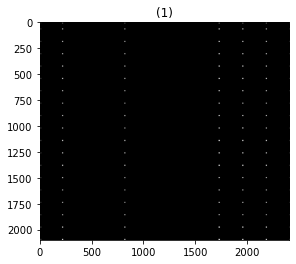

12.jpg


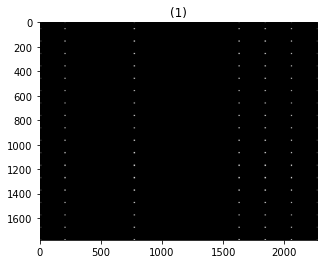

13.jpg


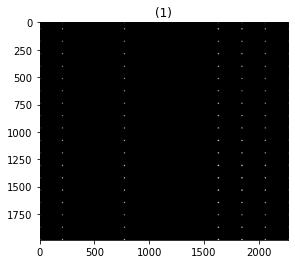

14.jpg


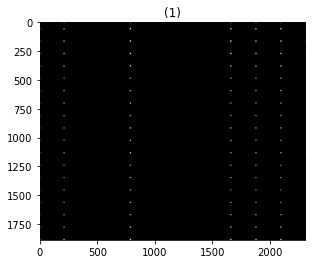

15.jpg


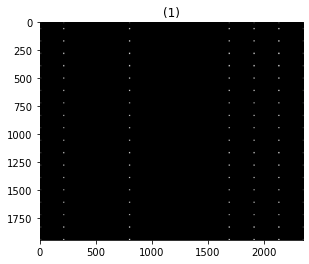

2.jpg


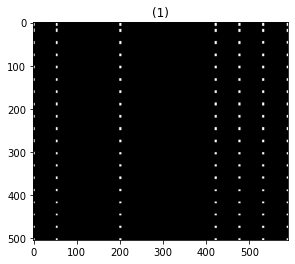

3.jpg


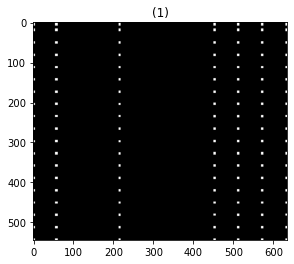

4.jpg


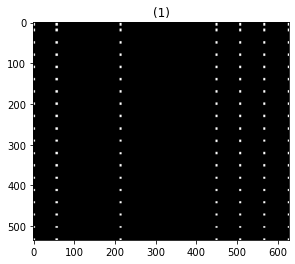

5.jpg


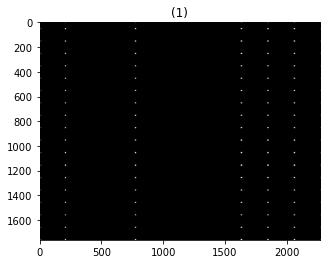

6.jpg


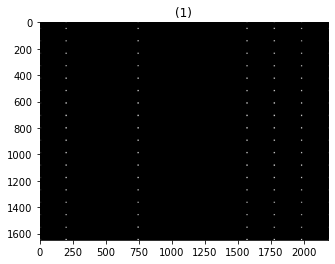

7.jpg


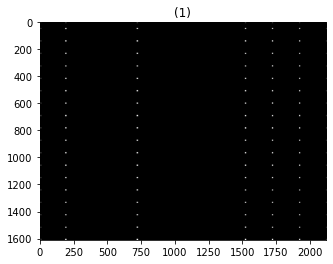

8.jpg


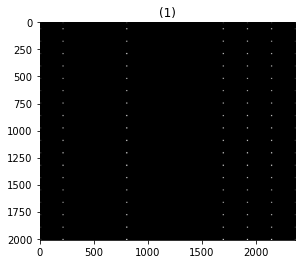

9.jpg


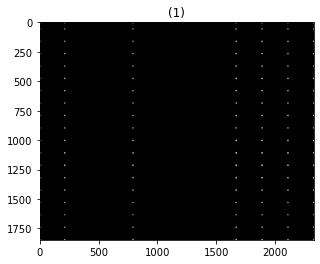

In [14]:
directory = './Samples'
for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        print(filename)
        img = cv2.imread(filepath)
        cur_image = Prespective_Transform(img)
        gray_image = cv2.cvtColor(cur_image, cv2.COLOR_BGR2GRAY)
        img_output = cv2.adaptiveThreshold(gray_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 45, 15)
        img_final = getCells(img_output)
        image_name = os.path.splitext(filename)[0]
        output_dir = f"results/{image_name}"
        cutCells(img_final, img_output,output_dir)

In [19]:
# # Install the required libraries
# pip install pytesseract pillow

##author:Mohamed Samir
## this cell is defined for all detection algorithms function to be used
#make sure to install all dependencies
import cv2
import pytesseract
from PIL import Image

# pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

#this does work on some hand written and doesnt work on else
def ocr_pytesseract_number_extraction(image_path):
    # Open the image using Pillow
    image = Image.open(image_path)

    
    #you can remove the config to detect the text if you want but we only using it for digits detection
    extracted_text = pytesseract.image_to_string(img, config='--psm 6 -c tessedit_char_whitelist=0123456789')

    return extracted_text

Extracted Text: 1180212



In [55]:
import os
def sorting_key(file_name):
        try:
            return int(file_name.split('_')[1].split('.')[0])
        except (IndexError, ValueError):
            return float('inf')  

def get_resultFiles_sorted(directory_path,startWord):
    # print(directory_path.split('/')[1].split('s')[0])
    files = os.listdir(directory_path)
    code_files = [file for file in files if file.startswith(startWord)]
    print(code_files)
    code_files.sort(key=sorting_key)
    return code_files





['Code_1.jpg', 'Code_10.jpg', 'Code_11.jpg', 'Code_12.jpg', 'Code_13.jpg', 'Code_14.jpg', 'Code_15.jpg', 'Code_16.jpg', 'Code_17.jpg', 'Code_2.jpg', 'Code_3.jpg', 'Code_4.jpg', 'Code_5.jpg', 'Code_6.jpg', 'Code_7.jpg', 'Code_8.jpg', 'Code_9.jpg']
['Code_1.jpg', 'Code_2.jpg', 'Code_3.jpg', 'Code_4.jpg', 'Code_5.jpg', 'Code_6.jpg', 'Code_7.jpg', 'Code_8.jpg', 'Code_9.jpg', 'Code_10.jpg', 'Code_11.jpg', 'Code_12.jpg', 'Code_13.jpg', 'Code_14.jpg', 'Code_15.jpg', 'Code_16.jpg', 'Code_17.jpg']
